In [1]:
import pandas as pd
import os
os.chdir(r"C:\Users\rishi\OneDrive\Documents\Notes\NLP\Project fot GIT")

In [2]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
df = pd.read_csv('Amazon_Unlocked_Mobile.csv',nrows=3000)
df = df.dropna(subset=['Reviews'])
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


# Pre Proccessing

In [7]:
# Convert to list
data = df.Reviews.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I feel so LUCKY to have found this used (phone to us & not used hard at '
 'all), phone on line from someone who upgraded and sold this one. My Son '
 'liked his old one that finally fell apart after 2.5+ years and didnt want an '
 'upgrade!! Thank you Seller, we really appreciate it & your honesty re: said '
 'used phone.I recommend this seller very highly & would but from them again!!']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['feel', 'so', 'lucky', 'to', 'have', 'found', 'this', 'used', 'phone', 'to', 'us', 'not', 'used', 'hard', 'at', 'all', 'phone', 'on', 'line', 'from', 'someone', 'who', 'upgraded', 'and', 'sold', 'this', 'one', 'my', 'son', 'liked', 'his', 'old', 'one', 'that', 'finally', 'fell', 'apart', 'after', 'years', 'and', 'didnt', 'want', 'an', 'upgrade', 'thank', 'you', 'seller', 'we', 'really', 'appreciate', 'it', 'your', 'honesty', 're', 'said', 'used', 'phone', 'recommend', 'this', 'seller', 'very', 'highly', 'would', 'but', 'from', 'them', 'again']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['feel', 'so', 'lucky', 'to', 'have', 'found', 'this', 'used', 'phone', 'to', 'us', 'not', 'used', 'hard', 'at', 'all', 'phone', 'on', 'line', 'from', 'someone_who', 'upgraded', 'and', 'sold', 'this', 'one', 'my', 'son', 'liked', 'his', 'old', 'one', 'that', 'finally', 'fell', 'apart', 'after', 'years', 'and', 'didnt', 'want', 'an', 'upgrade', 'thank', 'you', 'seller', 'we', 'really', 'appreciate', 'it', 'your', 'honesty', 're', 'said', 'used', 'phone', 'recommend', 'this', 'seller', 'very', 'highly', 'would', 'but', 'from', 'them', 'again']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['feel', 'lucky', 'find', 'use', 'phone', 'use', 'hard', 'phone', 'line', 'upgrade', 'sell', 'son', 'like', 'old', 'finally', 'fall', 'apart', 'year', 'do', 'want', 'upgrade', 'thank', 'seller', 'really', 'appreciate', 'honesty', 'say', 'use', 'phone', 'recommend', 'seller', 'highly']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 2), (23, 3), (24, 1), (25, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('apart', 1),
  ('appreciate', 1),
  ('do', 1),
  ('fall', 1),
  ('feel', 1),
  ('finally', 1),
  ('find', 1),
  ('hard', 1),
  ('highly', 1),
  ('honesty', 1),
  ('like', 1),
  ('line', 1),
  ('lucky', 1),
  ('old', 1),
  ('phone', 3),
  ('really', 1),
  ('recommend', 1),
  ('say', 1),
  ('sell', 1),
  ('seller', 2),
  ('son', 1),
  ('thank', 1),
  ('upgrade', 2),
  ('use', 3),
  ('want', 1),
  ('year', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.069*"phone" + 0.023*"get" + 0.022*"do" + 0.014*"buy" + 0.013*"work" + '
  '0.010*"problem" + 0.010*"month" + 0.010*"call" + 0.010*"try" + '
  '0.010*"time"'),
 (1,
  '0.093*"phone" + 0.044*"good" + 0.042*"great" + 0.026*"work" + 0.022*"love" '
  '+ 0.021*"price" + 0.017*"sim" + 0.016*"card" + 0.014*"case" + '
  '0.011*"excellent"'),
 (2,
  '0.041*"phone" + 0.020*"screen" + 0.015*"well" + 0.014*"good" + '
  '0.014*"camera" + 0.012*"battery" + 0.010*"get" + 0.010*"price" + '
  '0.009*"speaker" + 0.009*"really"')]


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.951163826484715

Coherence Score:  0.40664019287660014


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.041045 -0.206024       1        1  51.559260
0     -0.180989  0.134485       2        1  27.935170
1      0.222034  0.071539       3        1  20.505569, topic_info=       Term         Freq        Total Category  logprob  loglift
14    phone  5565.000000  5565.000000  Default  30.0000  30.0000
45     good  1535.000000  1535.000000  Default  29.0000  29.0000
31    great  1189.000000  1189.000000  Default  28.0000  28.0000
49     work   821.000000   821.000000  Default  27.0000  27.0000
46     love   418.000000   418.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
157     far   143.784712   255.480029   Topic3  -4.8915   1.0096
95      buy   199.360263   554.616553   Topic3  -4.5647   0.5613
1851    lte   117.808398   217.254917   Topic3  -5.0908   0.9725
89     need   128.369002   320.154173   Topic3  -5.0049   0.6706
34     nice   112.898169   361.414158   Topic3  -5.1333   0.4209

[202 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3064      1  0.744270   alcatel
3064      2  0.256093   alcatel
877       1  0.993489    almost
1659      1  0.984613   amazing
1659      3  0.012955   amazing
...     ...       ...       ...
683       3  0.965837      wife
1871      1  0.028552  wireless
1871      3  0.970759  wireless
49        2  0.404349      work
49        3  0.595562      work

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

# Building LDA Mallet Model

In [18]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:\new_mallet\mallet-2.0.8'

#import os
#from gensim.models.wrappers import LdaMallet

#os.environ['MALLET_HOME'] = 'C:\\Users\\rishi\\OneDrive\\Documents\\Notes\\NLP\\mallet-2.0.8\\mallet-2.0.8'
mallet_path =r'C:\new_mallet\mallet-2.0.8\bin\mallet.bat'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)


In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('phone', 0.05785391079508727),
   ('work', 0.03544494720965309),
   ('time', 0.022678302090066795),
   ('call', 0.021816418875242403),
   ('problem', 0.01750700280112045),
   ('charge', 0.015513897866839044),
   ('battery', 0.012874380521439344),
   ('make', 0.012766645119586296),
   ('bad', 0.012551174315880199),
   ('month', 0.012443438914027148)]),
 (1,
  [('phone', 0.2105294467578822),
   ('good', 0.05270672218917311),
   ('screen', 0.027721594289113624),
   ('buy', 0.027186198691255204),
   ('price', 0.025044616299821534),
   ('nice', 0.01980963712076145),
   ('review', 0.017311124330755503),
   ('give', 0.013920285544318858),
   ('purchase', 0.013265913146936347),
   ('case', 0.013087447947650209)]),
 (2,
  [('phone', 0.07034908471690081),
   ('great', 0.05592805449127288),
   ('love', 0.02559599829714772),
   ('sim', 0.02219029374201788),
   ('card', 0.020114942528735632),
   ('price', 0.018997445721583652),
   ('work', 0.017347807577692637),
   ('camera', 0.01623031077

# Finding the optimal number of topics for LDA

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)


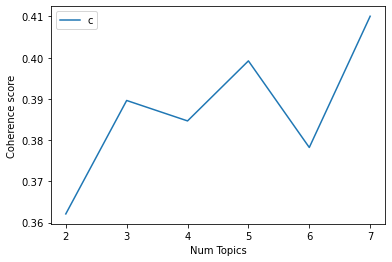

In [26]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3621
Num Topics = 3  has Coherence Value of 0.3896
Num Topics = 4  has Coherence Value of 0.3847
Num Topics = 5  has Coherence Value of 0.3992
Num Topics = 6  has Coherence Value of 0.3782
Num Topics = 7  has Coherence Value of 0.4101


In [30]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.102*"phone" + 0.038*"good" + 0.026*"love" + 0.023*"sim" + 0.021*"card" + '
  '0.015*"product" + 0.014*"review" + 0.014*"excellent" + 0.013*"feature" + '
  '0.012*"easy"'),
 (1,
  '0.138*"phone" + 0.048*"screen" + 0.044*"great" + 0.030*"app" + 0.026*"time" '
  '+ 0.016*"price" + 0.016*"update" + 0.015*"issue" + 0.013*"make" + '
  '0.013*"day"'),
 (2,
  '0.037*"good" + 0.022*"camera" + 0.022*"battery" + 0.020*"speaker" + '
  '0.016*"sound" + 0.014*"ve" + 0.014*"quality" + 0.014*"price" + 0.013*"idol" '
  '+ 0.013*"android"'),
 (3,
  '0.082*"phone" + 0.044*"work" + 0.036*"buy" + 0.013*"charge" + 0.013*"bad" + '
  '0.013*"month" + 0.011*"slow" + 0.011*"call" + 0.011*"money" + '
  '0.010*"battery"')]


In [31]:
import gensim    
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.382678  0.080073       1        1  27.916814
1     -0.160497 -0.240117       2        1  25.040144
0      0.011118 -0.130279       3        1  23.835592
3     -0.233299  0.290322       4        1  23.207450, topic_info=        Term         Freq        Total Category  logprob  loglift
14     phone  7259.000000  7259.000000  Default  30.0000  30.0000
45      good  1811.000000  1811.000000  Default  29.0000  29.0000
49      work  1188.000000  1188.000000  Default  28.0000  28.0000
31     great  1297.000000  1297.000000  Default  27.0000  27.0000
95       buy   771.000000   771.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
270     call   236.401201   495.577951   Topic4  -4.5181   0.7205
73   problem   182.125415   397.899360   Topic4  -4.7789   0.6792
84   battery   225.546044   793.088433   Topic4  -4.5651   0.2033
538   mobile   149.559943   260.022582   Topic4  -4.9759   0.9076
6       find   137.498658   300.283401   Topic4  -5.0600   0.6796

[288 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
508       2  0.061631         add
508       4  0.933265         add
876       3  1.018395  additional
3064      1  0.454960     alcatel
3064      4  0.545952     alcatel
...     ...       ...         ...
49        3  0.196104        work
49        4  0.803773        work
227       4  0.994919     working
231       2  1.003885       worth
25        4  0.999796        year

[294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

# Finding the dominant topic in each sentence

In [34]:
#optimal_model=lda_model

def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


# Find the most representative document for each topic

In [35]:
pd.options.display.max_colwidth = 1000
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet
#sent_topics_sorteddf_mallet.Text

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6796,"phone, good, love, sim, card, product, review, excellent, feature, easy","When I received this phone, I was very Impressed and the color are very cool we never had a color blue phone.Before I give the review I used it and I did try how good it is . For my own experience this phone it has a very bright and clear display and I really like thin frame ,light weight easy to hold very good quality super love love it..*** Lets talk about making a call ***This phone Has a very clear high quality sound when making and receiving calls I love to use it. Has a good signal reception works great to my T-Mobile prepaid simcard. I dont have any problem if I want to connect to the internet or free public Wifi very easy to access.I downloaded some Apps Amazon shopping , Messenger, Pandora and Farm heroes super saga etc. very fast Using this phone .***Camera Dual Camera and Dual Flash 2.0MP FRONT and 5.0MP Back *** clear and makes a good quality picture perfect for selfie.*** Dual simcard one slot for a regular simcard the one slot for the mini simcard and micro sd card on..."
1,1.0,0.5351,"phone, screen, great, app, time, price, update, issue, make, day","Decent phone, shame it died one day after the one year warranty ended. It was while I was playing kingdom hearts unchained x. Symptoms were: phone got hot, touch screen became unresponsive on and off, the next day blue screen, rebooted, another blue screen, then phone completely died.Dual front facing speakers that get nice and loud so thats a huge plus, mine came with jbl earbuds which is awesome considering how most phones dont even include them anymore. But, the placement of the auxiliary port is located at the top of the phone and this is weird because the mini usb port is located on the bottom. If you used one of those magnetic air vent phone holders for you car, things will get messy as theres no clear orientation to have good cable management when you want to plug the auxiliary cable to your phone while charging. However, the reversible design is nice so that you can make the auxiliary cable be located on the bottom relatively by putting the phone upside down.Coming from a s..."
2,2.0,0.6018,"good, camera, battery, speaker, sound, ve, quality, price, idol, android","Ive had ZTE AWE, LG G2, iPhone 5s, Idol 3 5.5"" and now Idol 3 4.7"".This phone is slim, light, and perfect size for the pocket and web browsing. The Idol 5.5"" was too large to keep comfortably in my pocket without breaking it.The screen has a yellower white, which I like better for reading. The screen of the Idol 5.5"" had a bright bluish white, which often hurt my eyes. Both screens are very reflective - remedied by a MATTE screen protector by Mr. Shield.The battery is 2000 mAh, which to my surprise is sufficient to stream Pandora on 4G the whole day. I always thought that I needed 3000 mAh for a whole day operation but the new version of Android is surprisingly battery efficient.The sound from the phone speakers is loud and clear with some depth, but definitely not with super bass or ""like from big speakers"", as some reviews are claiming. Strangely, the ringing and notifications are decreased in volume when headphones are plugged in - definitely a software bug that Alcatel has to s..."
3,3.0,0.5498,"phone, work, buy, charge, bad, month, slow, call, money, battery","This seems to be a great little phone.When I saw it would cost $700 to get a new Samsung to replace my old S3, I shopped around. I bought the Alcatel Idol 3 (4.7"") from Amazon and after a week am pretty much thrilled at how well it works.The setup had some bumps for me because my cloud files were not up to date. My advice here is to update your contacts, files (including downloads), and pictures before cluttering the new phone with junk So dont log in to your Google acount (yes, even just for email) until stuff is updated and synched up on the old phone.Also, perhaps because the Alcatel phone is ""un

# Topic distribution across documents

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([ topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = [ 'Num_Documents', 'Perc_Documents']

# Show


df_dominant_topics

,Num_Documents,Perc_Documents
0.0,1009,0.3363
3.0,831,0.2770
2.0,609,0.2030
1.0,551,0.1837


In [37]:
topic_counts

0.0    1009
3.0     831
2.0     609
1.0     551
Name: Dominant_Topic, dtype: int64

In [38]:
topic_contribution

0.0    0.3363
3.0    0.2770
2.0    0.2030
1.0    0.1837
Name: Dominant_Topic, dtype: float64

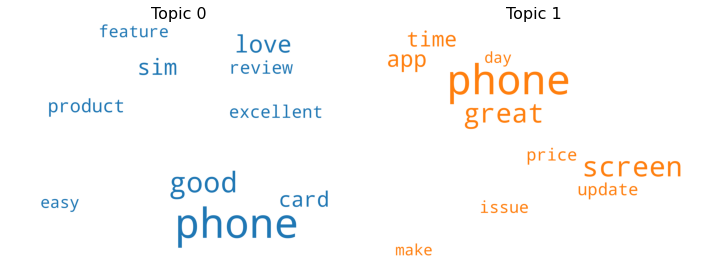

In [39]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-40-5476eb3dc9ea>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-40-5476eb3dc9ea>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


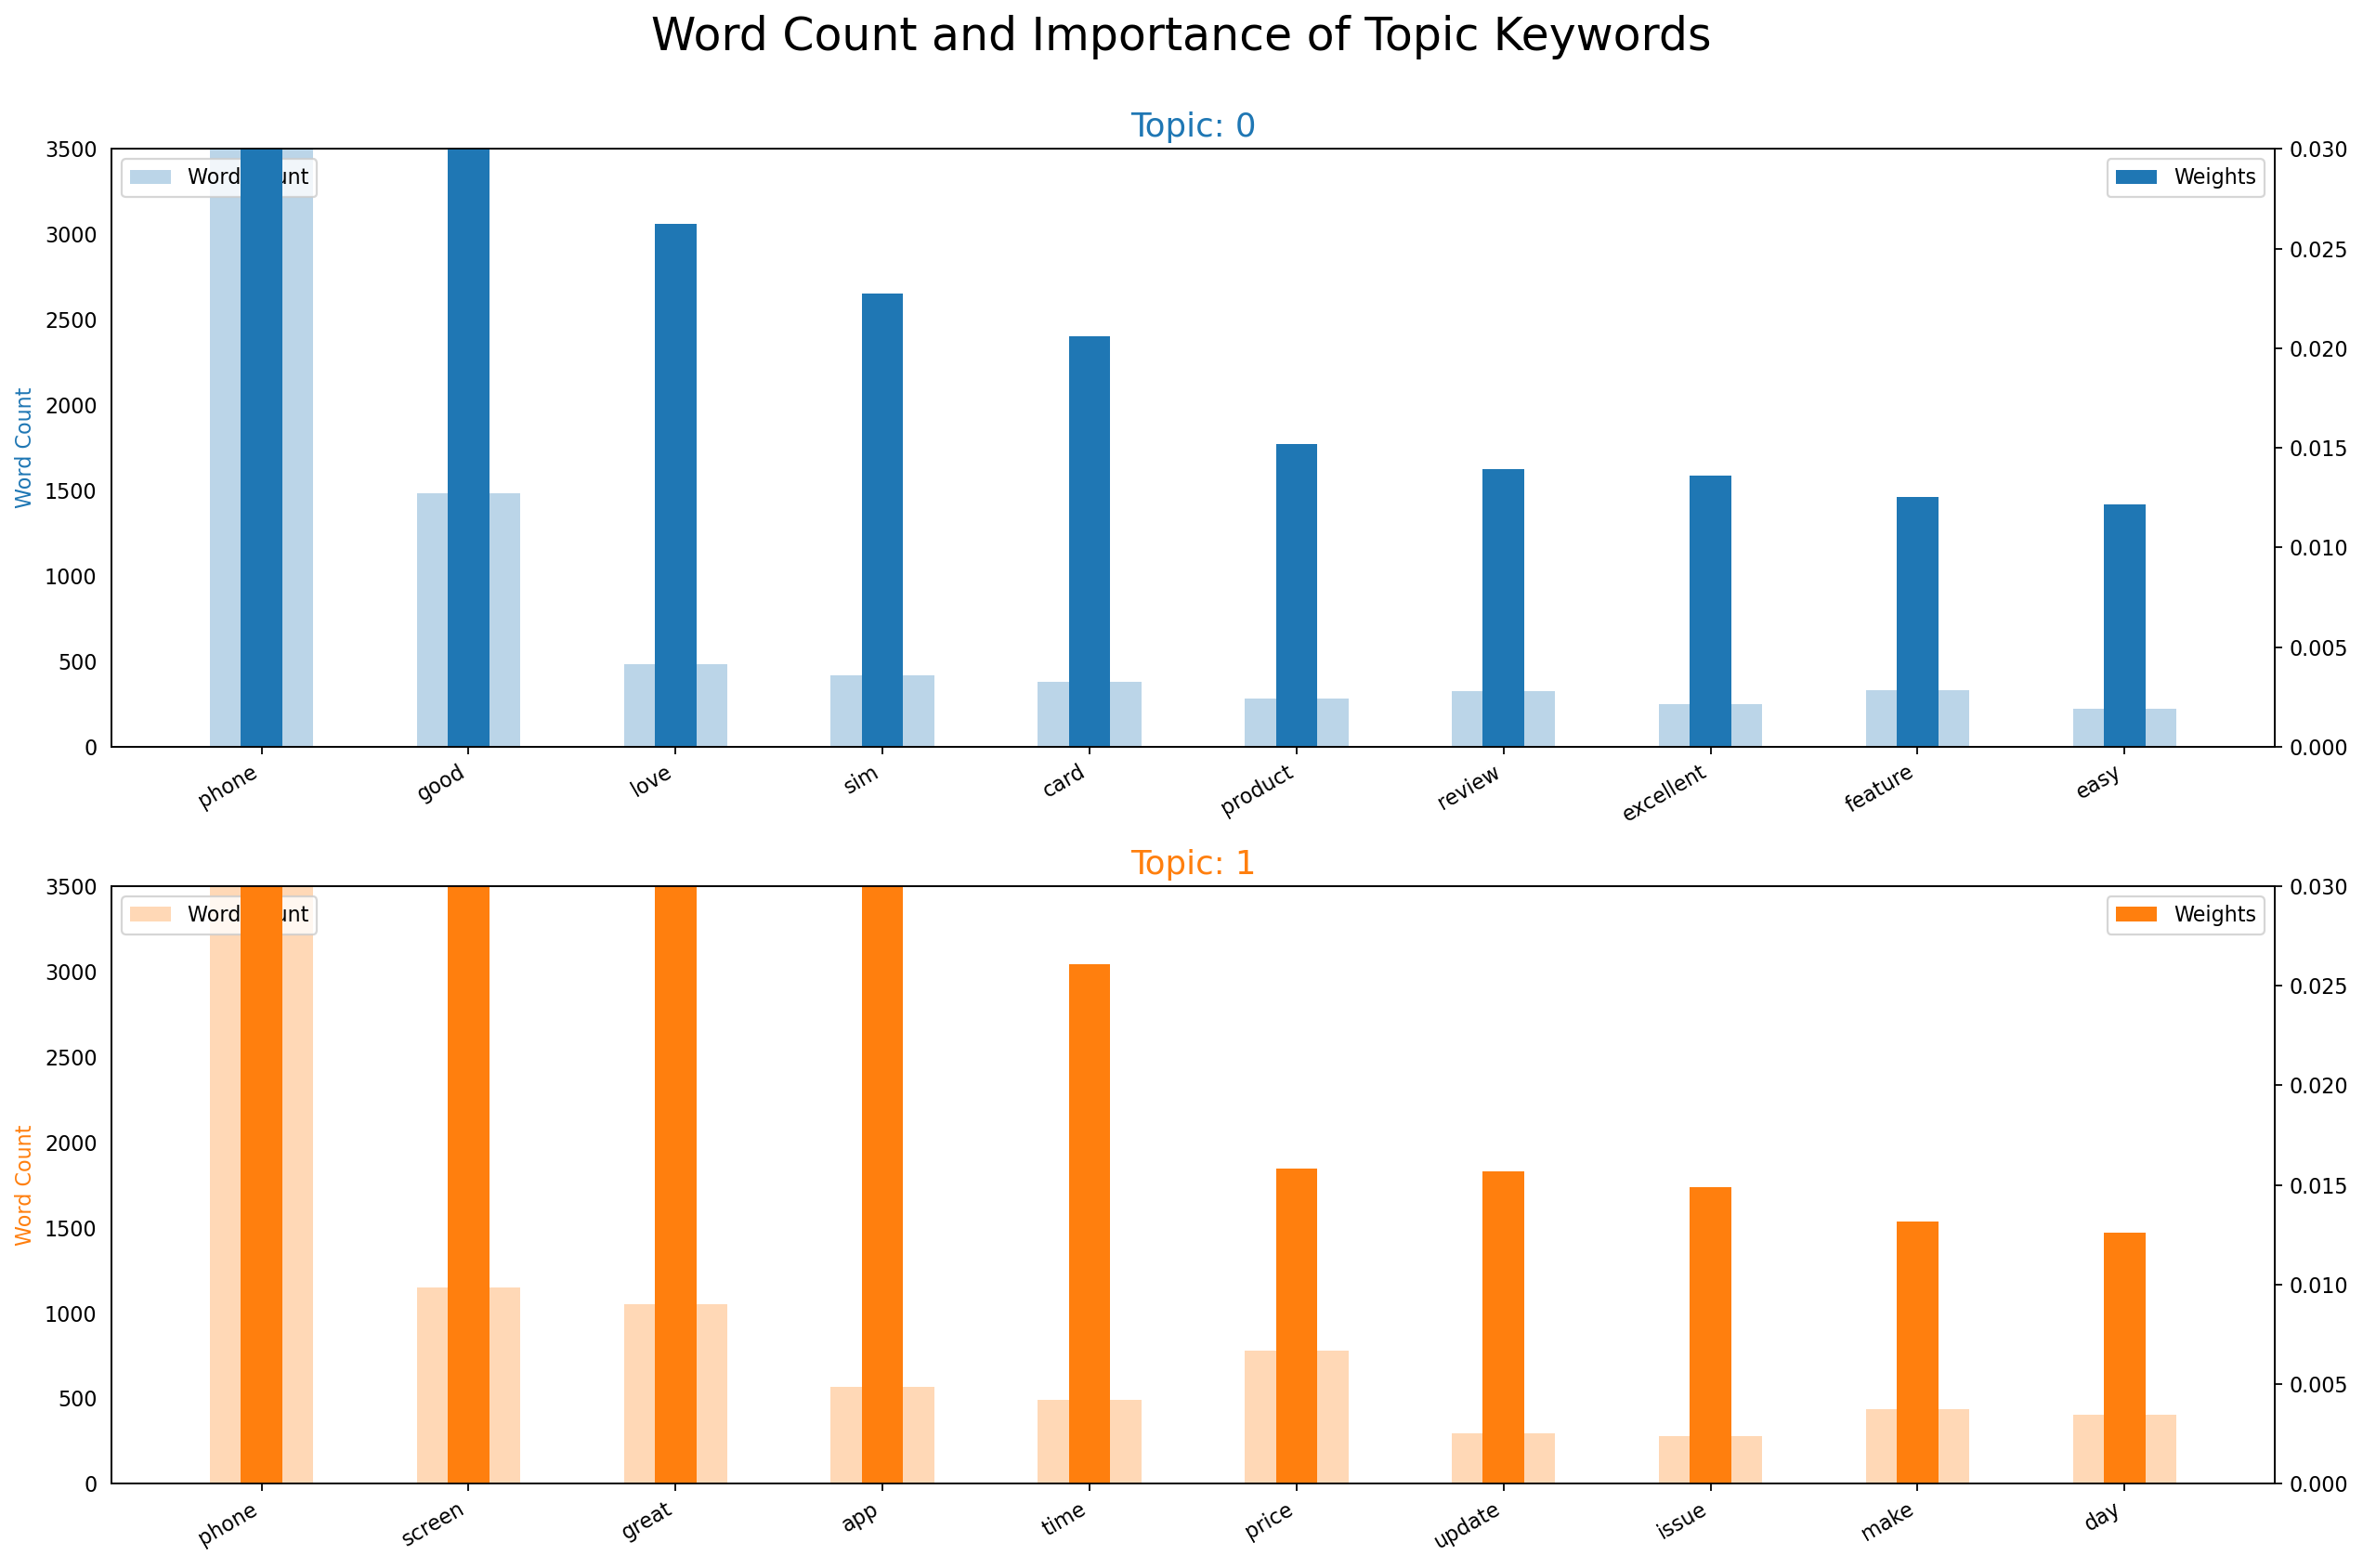

In [40]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 1, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()